**Deep Computer Vision Using Convolutional Neural Networks**

Tutorial trouvé sur le github de Aurélier Géron https://github.com/ageron/handson-ml2

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

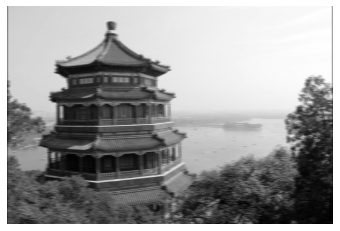

In [5]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

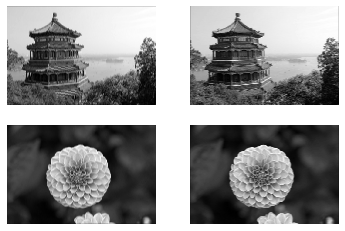

In [6]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [7]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


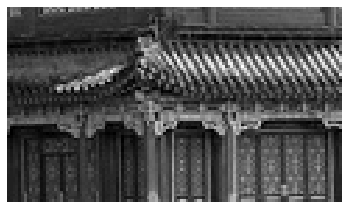

Saving figure china_vertical


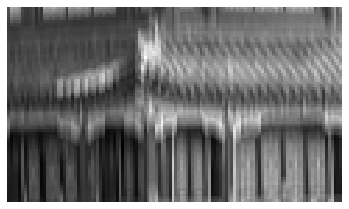

Saving figure china_horizontal


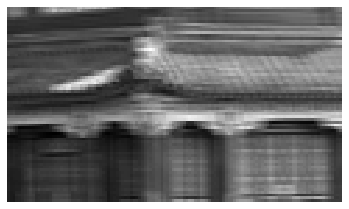

In [8]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

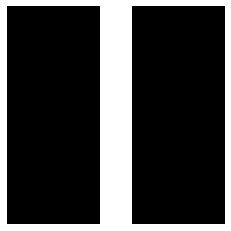

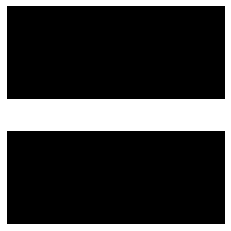

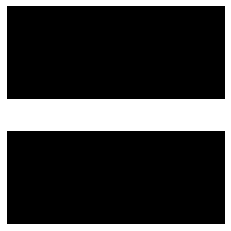

In [12]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

**Question:** Reprenez la partie précédente en remplacant les filtres par les 6 filtres définis dans le slide intitulé "Example of convolution filter example applied to image" de mon cours sur les CNN. Montrez les résultats.

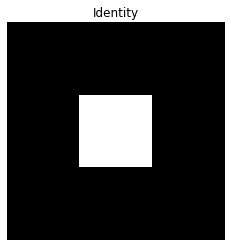

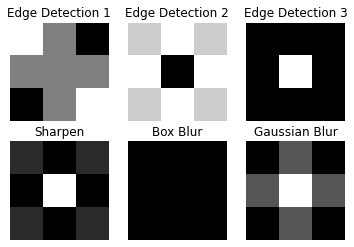

In [23]:
# Example of convolution filter example applied to image.
# Create 2 filters
filters_name = [
  "Identity", 
  "Edge Detection 1", 
  "Edge Detection 2", 
  "Edge Detection 3",
  "Sharpen",
  "Box Blur",
  "Gaussian Blur"
]

filters = np.zeros(shape=(3, 3, channels, 7), dtype=np.float32)
filters[1, 1, :, 0] = 1  # Identité
# Edge Detection 1
filters[0, 0, :, 1] = 1  # Edge 1
filters[2, 2, :, 1] = 1  # Edge 1
filters[0, 2, :, 1] = -1  # Edge 1
filters[2, 0, :, 1] = -1  # Edge 1

# Edge Detection 2
filters[1, :, :, 2] = 1  # Edge 1
filters[:, 1, :, 2] = 1  # Edge 1
filters[1, 1, :, 2] = -4  # Edge 1

# Edge Detection 3
filters[:, :, :, 3] = -1 # Edge3
filters[1, 1, :, 3] = 8

# Sharpen
filters[1, :, :, 4] = -1  # Edge 1
filters[:, 1, :, 4] = -1  # Edge 1
filters[1, 1, :, 4] = 5  # Edge 1

# box Blur
filters[:, :, :, 5] = 1/9 # Edge3

# Gaussian Blur
filters[:, :, :, 6] = 1 # Edge3
filters[1, :, :, 6] = 2  # Edge 1
filters[:, 1, :, 6] = 2  # Edge 1
filters[1, 1, :, 6] = 4  # Edge 1
filters[:, :, :, 6] *= 1/16

plot_image(filters[:,:,0,0])
plt.title(filters_name[0])
plt.show()

for i in range(1,len(filters_name)):
  plt.subplot(2,3,i)
  plot_image(filters[:,:,1,i])
  plt.title(filters_name[i])
plt.show()



## Convolutional Layer

Using `keras.layers.Conv2D()`:

In [24]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,padding="SAME", activation="relu")

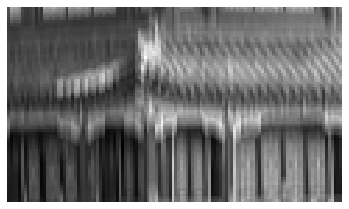

In [26]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

## VALID vs SAME padding

In [27]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [28]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [29]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [31]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

## Max pooling

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## Average pooling

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

# Tackling Fashion MNIST With a CNN

In [ ]:
# séparation du dataset en trois ensembles
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# normalisation (notez bien que la moyenne et std sont estimés sur le training set)
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
from functools import partial

# la fonction partial permet de fixer 
# les paramètres d'une fonction (ici keras.layers.Conv2D)
# aux valeurs spécifiés (ici kernel_size=3, activation='relu', padding="SAME")
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

# définition de l'architecture
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
# compilation et entrainement
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

## Using a Pretrained Model

In [ ]:
# téléchargement et construction du modèle avec les poids déjà entrainés sur le dataset imagenet
model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [ ]:
# le modèle n'accepte n'importe quelle taille (c'est un réseau de convolution!)
# mais comme on fait une décomposition hiérarchique (présence de pooling), la taille minimum des images doit être de [224,224]
# par ailleurs pour l'apprentissage il faut des images de taille fixe.
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

In [ ]:
# illustration du padding
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

In [ ]:
# illustration du cropping
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

In [ ]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [ ]:
# The pretrained models assume that the images are preprocessed in a specific way. 
# In some cases they may expect the inputs to be scaled from 0 to 1, or -1 to 1, and so on.
# Each model provides a preprocess_input() function that you can use to preprocess
# your images. These functions assume that the pixel values range from 0 to 255, so we
# must multiply them by 255 (since earlier we scaled them to the 0–1 range)

inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

# Now we can use the pretrained model to make predictions:
Y_proba = model.predict(inputs)

In [ ]:
Y_proba.shape

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

The correct classes (monastery and daisy) appear in the top 3 results for both images.
That’s pretty good considering that the model had to choose among 1,000 classes.

As you can see, it is very easy to create a pretty good image classifier using a pre‐
trained model. Other vision models are available in keras.applications , including
several ResNet variants, GoogLeNet variants like InceptionV3 and Xception,
VGGNet variants, MobileNet and MobileNetV2 (lightweight models for use in
mobile applications), and more.

But what if you want to use an image classifier for classes of images that are not part
of ImageNet? In that case, you may still benefit from the pretrained models to per‐
form transfer learning.

## Pretrained Models for Transfer Learning

let’s train a model to classify pictures of flowers, reusing a pretrained Xception model. First, let’s load the dataset using TensorFlow Datasets

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [ ]:
info.splits

In [ ]:
info.splits["train"]

In [ ]:
class_names = info.features["label"].names
class_names

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

The [new split API](https://www.tensorflow.org/datasets/splits) (called S3) is much simpler to use:

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Basic preprocessing:

In [ ]:
# The CNN expects 224 × 224 images, so we need
# to resize them. We also need to run the image through Xception’s preprocess_input() function:
    
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [ ]:
# If you want to perform some data augmentation, you can just change the preprocess‐
# ing function for the training set, adding some random transformations to the training
# images. For example, use tf.image.random_crop() to randomly crop the images, use
# tf.image.random_flip_left_right() to randomly flip the images horizontally, and
# so on .

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# Let’s apply this preprocessing function to all 3 datasets, and let’s also shuffle & repeat
# the training set, and add batching & prefetching to all datasets:
    
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Let’s load an Xception model, pretrained on ImageNet. We exclude the top of the network (by setting include_top=False ): this excludes the global average pooling layer and the dense output layer (the classifier). We then add our own global average pooling layer,based on the output of the base model, followed by a dense output layer with 1 unit per class, using the softmax activation function. Finally, we create the Keras Model :

In [ ]:
# chargement du feature extractor (sans classifieur include_top=False)
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

# on rajoute séquentiellement des couches de classification
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

# on a recréé le modèle en liant l'entrée de base_model à la sortie 
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# check the model architecture (ou model.summary)
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)



it’s usually a good idea to freeze the weights (fine) of the pretrained layers, at least at the beginning of training


In [ ]:
# Principe du fine-tuning = on fixe le feature extractor pendant l'apprentissage
for layer in base_model.layers:
    layer.trainable = False

# Since our model uses the base model’s layers directly, rather than the base_model object itself 
# (i.e. on a recréé le modèle à partir des layers avec l'appel à keras.models.Model), 
# setting base_model.trainable=False
# would have no effect.

# apprentissage
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

After training the model for a few epochs, its validation accuracy should reach about 75-80%, and stop making much progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all layers (or you could try unfreezing just the top ones), and continue training (don’t forget to compile the model when you freeze or unfreeze layers). This

In [ ]:
# 
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

It will take a while, but this model should reach around 95% accuracy on the test set.
With that, you can start training amazing image classifiers! But there’s more to com‐
puter vision than just classification. For example, what if you also want to know where
the flower is in the picture? Let’s look at this now.